(transformers)=
# Transformers para NER 

Para hacer una introducción practica a los transformadores, vamos a explorar como un modelo de transformador llamado XLM-RoBERTa nos permitte cumplir con la tarea.  Al igual que BERT, estos modelos utilizan el modelado lingüístico enmascarado como objetivo de preentrenamiento, pero se entrenan conjuntamente con textos en más de cien idiomas. Al entrenarse previamente en enormes corpus de muchas lenguas, estos transformadores multilingües permiten la transferencia multilingüe sin necesidad de realizar ningún disparo. Esto significa que un modelo perfeccionado en una lengua puede aplicarse a otras sin necesidad de más entrenamiento. Aunque no es nuestro objetivo en esta parte, sería interesante probarlo con nuestos datos jurídicos multilingue en concreto sobre los datos en catalan. Ademas es el modelo utilizado por los autores de Flert {cite}`Schweter2020FLERTDF` y tenemos resultados para el en 3 de las configuraciónes probadas.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings

os.environ["CUDA_VISIBLE_DEVICES"]="1"
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=PicklingWarning)

##  Dataset

In [2]:
import codecs
from dataclasses import asdict, dataclass, field
from typing import DefaultDict, List

from datasets import ClassLabel, Dataset, DatasetDict, Features, Sequence, Value
from spacy.tokens import Token

from meddocan.data import ArchiveFolder
from meddocan.data.docs_iterators import GsDocs


@dataclass
class Rows:
    origin: List[str] = field(default_factory=list)
    text: List[str] = field(default_factory=list)
    input_ids: List[str] = field(default_factory=list)
    tokens: List[List[str]] = field(default_factory=list)
    ner_tags: List[List[str]] = field(default_factory=list)


def get_tok_tag(token: Token) -> str:
    if (tag := token.ent_iob_) in ["", "O"]:
        tag = "O"
    else:
        tag = f"{tag}-{token.ent_type_}"
    text = token.text
    if text[0].encode("utf-8") == codecs.BOM_UTF8:

        # Remove the detected BOOM.
        # If not removed, the ﻿ sign sometimes appears in
        # documents in BIO format opened by vscode.

        text = text[1:]

    return text, tag


def meddocan(folder: str = None) -> Dataset:
    archives = (ArchiveFolder.train, ArchiveFolder.dev, ArchiveFolder.test)

    label_count = DefaultDict(int)
    dataset_dict = DefaultDict(Dataset)
    store_rows = DefaultDict(Rows)

    for archive in archives:
        brat_docs = GsDocs(archive)
        rows = Rows()
        input_ids = 0
        for brat_doc in brat_docs:
            for sent in brat_doc.doc.sents:

                # Read text and corresponding tag -> TOKEN, IOB
                tokens, iobs = zip(*map(get_tok_tag, sent))
                if not tokens[-1].strip():  # Remove "\n" tokens
                    tokens, iobs = tokens[:-1], iobs[:-1]
                for iob in iobs:
                    label_count[iob] += 1
                input_ids += 1

                # Get index of the key in label_count
                llc = list(label_count)
                idx = list(map(llc.index, iobs))

                # Fill Rows Dataclass
                rows.origin.append(brat_doc.brat_files_pair.txt.at)
                rows.text.append(sent.text.strip())
                rows.input_ids.append(input_ids)
                rows.tokens.append(tokens)
                rows.ner_tags.append(idx)

        store_rows[archive.value] = rows

    features = Features(
        {
            "origin": Value("string"),
            "text": Value("string"),
            "input_ids": Value("int32"),
            "tokens": Sequence(Value("string")),
            "ner_tags": Sequence(
                ClassLabel(names=list(label_count.keys()))
            ),
        }
    )
    for archive in archives:
        dataset_dict[archive.value] = Dataset.from_dict(
            asdict(store_rows[archive.value]), features, split=archive.value
        )

    # Construct the DatasetDict
    return DatasetDict(dataset_dict)

ds = meddocan()

Utilizamos la function ``meddocan()`` para crear una instancía de ``datasets.DatasetDict`` llamda ``ds``. Nuestro dictionario de dataset esta compuesto de 3 ``datasets.Dataset``, el de entrenamiento, de validación y de test.

In [3]:
for split in ds.keys():
    ds[split] = ds[split].shuffle(seed=0)

Aqui utilizamos el metodo ``shuffle`` para evitar un sesgue accidental en los datos.

Veamos cuántos ejemplos o frases tenemos por cada dataset accediendo al atributo ``Dataset.num_rows``:

In [4]:
import pandas as pd

pd.DataFrame({k: v.num_rows for k, v in ds.items()}, index=["number of example per split"])

,train,dev,test
number of example per split,10312,5268,5155


Veamos un ejemplo extraído del conjunto de datos

In [5]:
pd.DataFrame(ds["train"][11:12], index=["Sentence"]).T

,Sentence
origin,train/brat/S0212-71992006000800008-1.txt
text,NASS: 99 00154744 02.
input_ids,3651
tokens,"[NASS, :, 99, 00154744, 02, .]"
ner_tags,"[0, 0, 4, 5, 5, 0]"


En nuestros objetos ``Dataset``, las claves de nuestro ejemplo corresponden a los nombres de las columnas de una tabla Arrow [^4], mientras que los valores denotan las entradas de cada columna. En particular, vemos que la columna ``ner_tags`` corresponde a la asignación de cada entidad a un ID de clase. Esto es un poco críptico para el ojo humano, así que vamos a crear una nueva columna con las conocidas etiquetas. Para ello, lo primero que hay que observar es que nuestro objeto ``Dataset`` tiene un atributo features que especifica los tipos de datos subyacentes asociados a cada columna:

[^4]: https://huggingface.co/docs/datasets/about_arrow

In [6]:
for k, v in ds["train"].features.items():
    print(f"{k}: {v}")

origin: Value(dtype='string', id=None)
text: Value(dtype='string', id=None)
input_ids: Value(dtype='int32', id=None)
tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=45, names=['O', 'B-NOMBRE_SUJETO_ASISTENCIA', 'I-NOMBRE_SUJETO_ASISTENCIA', 'B-ID_SUJETO_ASISTENCIA', 'B-ID_ASEGURAMIENTO', 'I-ID_ASEGURAMIENTO', 'B-CALLE', 'I-CALLE', 'B-TERRITORIO', 'B-FECHAS', 'I-FECHAS', 'B-PAIS', 'B-EDAD_SUJETO_ASISTENCIA', 'I-EDAD_SUJETO_ASISTENCIA', 'B-SEXO_SUJETO_ASISTENCIA', 'B-NOMBRE_PERSONAL_SANITARIO', 'I-NOMBRE_PERSONAL_SANITARIO', 'B-ID_TITULACION_PERSONAL_SANITARIO', 'I-ID_TITULACION_PERSONAL_SANITARIO', 'B-CORREO_ELECTRONICO', 'I-CORREO_ELECTRONICO', 'B-HOSPITAL', 'I-HOSPITAL', 'B-FAMILIARES_SUJETO_ASISTENCIA', 'I-FAMILIARES_SUJETO_ASISTENCIA', 'I-TERRITORIO', 'B-OTROS_SUJETO_ASISTENCIA', 'B-INSTITUCION', 'I-INSTITUCION', 'I-PAIS', 'B-NUMERO_TELEFONO', 'I-NUMERO_TELEFONO', 'B-ID_CONTACTO_ASISTENCIAL', 'B-NUMERO_FA

La clase ``Sequence`` especifica que el campo contiene una lista de características, que en el caso de ``ner_tags`` corresponde a una lista de características ``ClassLabel``. Seleccionemos esta característica del conjunto de entrenamiento de la siguiente manera:

In [7]:
tags = ds["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=45, names=['O', 'B-NOMBRE_SUJETO_ASISTENCIA', 'I-NOMBRE_SUJETO_ASISTENCIA', 'B-ID_SUJETO_ASISTENCIA', 'B-ID_ASEGURAMIENTO', 'I-ID_ASEGURAMIENTO', 'B-CALLE', 'I-CALLE', 'B-TERRITORIO', 'B-FECHAS', 'I-FECHAS', 'B-PAIS', 'B-EDAD_SUJETO_ASISTENCIA', 'I-EDAD_SUJETO_ASISTENCIA', 'B-SEXO_SUJETO_ASISTENCIA', 'B-NOMBRE_PERSONAL_SANITARIO', 'I-NOMBRE_PERSONAL_SANITARIO', 'B-ID_TITULACION_PERSONAL_SANITARIO', 'I-ID_TITULACION_PERSONAL_SANITARIO', 'B-CORREO_ELECTRONICO', 'I-CORREO_ELECTRONICO', 'B-HOSPITAL', 'I-HOSPITAL', 'B-FAMILIARES_SUJETO_ASISTENCIA', 'I-FAMILIARES_SUJETO_ASISTENCIA', 'I-TERRITORIO', 'B-OTROS_SUJETO_ASISTENCIA', 'B-INSTITUCION', 'I-INSTITUCION', 'I-PAIS', 'B-NUMERO_TELEFONO', 'I-NUMERO_TELEFONO', 'B-ID_CONTACTO_ASISTENCIAL', 'B-NUMERO_FAX', 'I-NUMERO_FAX', 'B-CENTRO_SALUD', 'I-CENTRO_SALUD', 'I-ID_SUJETO_ASISTENCIA', 'I-OTROS_SUJETO_ASISTENCIA', 'B-PROFESION', 'I-PROFESION', 'I-SEXO_SUJETO_ASISTENCIA', 'B-ID_EMPLEO_PERSONAL_SANITARIO', 'I-ID_EMPLEO_PERSO

Podemos utilizar el método ``ClassLabel.int2str()`` para crear una nueva columna en nuestro conjunto de entrenamiento con nombres de clases para cada etiqueta. Usaremos el método ``map()`` para devolver un ``dict`` con la clave correspondiente al nuevo nombre de la columna y el valor como una ``lista`` de nombres de clases:

In [8]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

ds = ds.map(create_tag_names)

  0%|          | 0/10312 [00:00<?, ?ex/s]

  0%|          | 0/5268 [00:00<?, ?ex/s]

  0%|          | 0/5155 [00:00<?, ?ex/s]

Ahora que tenemos nuestras etiquetas en formato legible para el ser humano, veamos cómo se alinean los tokens y las etiquetas para el primer ejemplo del conjunto de entrenamiento:

In [9]:
ds_example = ds["train"][12]
pd.DataFrame([ds_example["tokens"], ds_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,Fecha,de,nacimiento,:,01,/,01,/,1987,.
Tags,O,O,O,O,B-FECHAS,I-FECHAS,I-FECHAS,I-FECHAS,I-FECHAS,O


Como comprobación rápida de que no tenemos ningún desequilibrio inusual en las etiquetas, calculemos las frecuencias de cada entidad en cada división:

In [10]:
from collections import Counter

split2freqs = DefaultDict(Counter)
for split, dataset in ds.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
class_freq = pd.DataFrame.from_dict(split2freqs, orient="index").fillna(0)
class_freq.T

,train,dev,test
ID_CONTACTO_ASISTENCIAL,77.0,32.0,39.0
PAIS,713.0,347.0,363.0
FECHAS,1231.0,724.0,611.0
NOMBRE_PERSONAL_SANITARIO,1000.0,497.0,501.0
INSTITUCION,98.0,72.0,67.0
CALLE,862.0,434.0,413.0
TERRITORIO,1875.0,987.0,956.0
CORREO_ELECTRONICO,469.0,241.0,249.0
EDAD_SUJETO_ASISTENCIA,1035.0,521.0,518.0
SEXO_SUJETO_ASISTENCIA,925.0,455.0,461.0


Esto tiene buena pinta: las distribuciones de las frecuencias de nuestras etiquetas son más o menos las mismas para cada división, por lo que los conjuntos de validación y prueba deberían proporcionar una buena medida de la capacidad de generalización de nuestro etiquetador NER. A continuación, vamos a ver algunos transformadores multilingües populares y cómo se pueden adaptar para abordar nuestra tarea NER.

## Transformadores multi-idiomas

Los transformadores multilingües tienen arquitecturas y procedimientos de entrenamiento similares a los de sus homólogos monolingües, con la salvedad de que el corpus utilizado para el preentrenamiento consta de documentos en muchos idiomas. Una característica notable de este enfoque es que, a pesar de no recibir información explícita para diferenciar entre las lenguas, las representaciones lingüísticas resultantes son capaces de generalizar bien entre las lenguas para una variedad de tareas posteriores. En algunos casos, esta capacidad de transferencia entre lenguas puede producir resultados que compiten con los de los modelos monolingües, lo que evita la necesidad de entrenar un modelo por lengua.

Para medir el progreso de la transferencia multilingüe para la NER, se suelen utilizar los conjuntos de datos ``CoNLL-2002`` y ``CoNLL-2003`` como referencia para el inglés, el holandés, el español y el alemán. Esta referencia consiste en artículos de noticias anotados con las categorías ``LOC``, ``PER`` y ``ORG`` que son diferentes de las categorías de MEDDOCAN. Los modelos de transformadores multilingües suelen evaluarse de tres maneras diferentes:

en
: Se ajustan a los datos de entrenamiento en inglés y luego se evalúan en el conjunto de pruebas de cada idioma. En el caso de nuetros datos jurídicos se podria ajustar sobre nuestros datos en castellano y evaluar sobre nuestros datos en catalan.

Cada uno de ellos
: Se ajustan y evalúan en datos de prueba monolingües para medir el rendimiento por idioma.

Todos
: Ajuste fino en todos los datos de entrenamiento para evaluar en todos los conjuntos de prueba de cada idioma.

En nuestra tarea NER solo nos centraremos en la primera parte. Uno de los primeros transformadores multilingües fue mBERT, que utiliza la misma arquitectura y el mismo objetivo de preentrenamiento que BERT, pero añade artículos de Wikipedia de muchos idiomas al corpus de preentrenamiento. Desde entonces, mBERT ha sido sustituido por XLM-RoBERTa (o XLM-R para abreviar), por lo que ese es el modelo que consideraremos en este capítulo.

XLM-R sólo utiliza MLM (Masked Language Model) como objetivo de preentrenamiento para 100 idiomas, pero se distingue por el enorme tamaño de su corpus de preentrenamiento en comparación con sus predecesores: Volcados de Wikipedia para cada idioma y 2,5 terabytes de datos de Common Crawl de la web. Este corpus es varios órdenes de magnitud más grande que los utilizados en modelos anteriores y proporciona un aumento significativo de la señal para las lenguas con pocos recursos, como el birmano y el suajili, donde sólo existe un pequeño número de artículos de Wikipedia.

La parte RoBERTa {cite}`Liu2019RoBERTaAR` del nombre del modelo hace referencia al hecho de que el enfoque de preentrenamiento es el mismo que el de los modelos monolingües RoBERTa. Los desarrolladores de RoBERTa mejoraron varios aspectos de BERT, en particular eliminando por completo la tarea de predicción de la siguiente frase. XLM-R también abandona los embeddings lingüísticos utilizados en XLM y utiliza SentencePiece {cite}`Kudo2018SentencePieceAS` para tokenizar los textos en bruto directamente. Además de su naturaleza multilingüe, una diferencia notable entre XLM-R y RoBERTa es el tamaño de los respectivos vocabularios: ¡250.000 tokens frente a 55.000!

XLM-R es una gran opción para las tareas de NLU multilingüe. En la siguiente sección, exploraremos cómo puede tokenizar eficientemente en castellano.

## Una mirada más cercana a la tokenización

En lugar de utilizar un tokenizador de WordPiece, XLM-R utiliza un tokenizador llamado SentencePiece que está entrenado en el texto orignal de los cien idiomas. Para ver cómo se compara SentencePiece con WordPiece, carguemos los tokenizadores BERT para el castellano y XLM-R de la forma habitual con hugginface *Transformers*:

In [11]:
from transformers import AutoTokenizer

bert_model_name = "dccuchile/bert-base-spanish-wwm-cased"
xlmr_model_name = "xlm-roberta-large"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Al codificar una pequeña secuencia de texto también podemos recuperar los tokens especiales que cada modelo utilizó durante el preentrenamiento:

In [12]:
text = "Jack Sparrow ama Nueva York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()
pd.DataFrame([bert_tokens, xlmr_tokens], ["BERT", "XLM-R"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
BERT,[CLS],J,##ac,##k,Spar,##ro,##w,ama,Nueva,Yor,##k,!,[SEP]
XLM-R,<s>,▁Jack,▁Spar,row,▁ama,▁Nueva,▁York,!,</s>,None,None,None,None


Aquí vemos que en lugar de los tokens ``[CLS]`` y ``[SEP]`` que BERT utiliza para las tareas de clasificación de frases, XLM-R utiliza ``<s>`` y ``<s>`` para denotar el comienzo y el final de una secuencia. Estos tokens se añaden en la etapa final de la tokenización, como veremos a continuación.

### La tubería del tokenizador

Hasta ahora hemos tratado la tokenización como una única operación que transforma las cadenas en enteros que podemos pasar por el modelo. Esto no es del todo exacto, y si echamos un vistazo más de cerca podemos ver que en realidad es una tubería de procesamiento completa que normalmente consta de cuatro pasos, como se muestra en la {numref}`brat-annotator-visualization`.

```{figure} ../figures/transformers_tokenizer-pipeline.png
:align: center
:name: brat-annotator-visualization

Las etapas en la tuberia de tokenización
```

Veamos con más detalle cada paso del procesamiento e ilustremos su efecto con la frase de ejemplo "¡Jack Sparrow ama Nueva York!":

Normalización
: Este paso corresponde al conjunto de operaciones que se aplican a una cadena sin procesar para hacerla más "limpia". Las operaciones más comunes son la eliminación de los espacios en blanco y de los caracteres acentuados. La [normalización Unicode](https://unicode.org/reports/tr15/) es otra operación de normalización común que aplican muchos tokenizadores para hacer frente al hecho de que a menudo existen varias formas de escribir el mismo carácter. Esto puede hacer que dos versiones de la "misma" cadena (es decir, con la misma secuencia de caracteres abstractos) parezcan diferentes; los esquemas de normalización Unicode como NFC, NFD, NFKC y NFKD sustituyen las diversas formas de escribir el mismo carácter por formas estándar. Otro ejemplo de normalización es el de las minúsculas. Si se espera que el modelo sólo acepte y utilice caracteres en minúsculas, esta técnica puede utilizarse para reducir el tamaño del vocabulario que requiere. Después de la normalización, nuestra cadena de ejemplo se vería como "¡Jack Sparrow ama Nueva York!". 

```{note}
En le caso del corpus Meddocan, hemos quitado los espacios asi como los saltos a la linea a la hora de entrenar el modelo con Flair.
```

Pretokenización
: Este paso divide un texto en objetos más pequeños que dan un límite superior a lo que serán sus tokens al final del entrenamiento (Es la tarea de la cual se encargar el ``meddocan.language.pipeline.meddocan_pipeline``. Una buena manera de pensar en esto es que el pretokenizador dividirá el texto en "palabras", y los tokens finales serán partes de esas palabras. En los idiomas que lo permiten (el inglés, el alemán y muchos idiomas indoeuropeos), las cadenas pueden dividirse en palabras a partir de los espacios en blanco y la puntuación. Por ejemplo, este paso podría transformar nuestras ["Jack", "Sparrow", "ama", "Nueva", "York", "!"]. A continuación, estas palabras son más sencillas de dividir en subpalabras con los algoritmos Byte-Pair Encoding (BPE) o Unigram en el siguiente paso de la cadena. Sin embargo, la división en "palabras" no siempre es una operación trivial y determinista, ni siquiera una operación que tenga sentido. Por ejemplo, en lenguas como el chino, el japonés o el coreano, la agrupación de símbolos en unidades semánticas como las palabras indoeuropeas puede ser una operación no determinista con varios grupos igualmente válidos. En este caso, podría ser mejor no pretokenizar el texto y, en su lugar, utilizar una biblioteca específica del idioma para la pretokenización.

Modelo de tokenización
: Una vez normalizados y pretokenizados los textos de entrada, el tokenizador aplica un modelo de división de subpalabras a las palabras. Esta es la parte de la cadena de producción que debe ser entrenada en su corpus (o que ha sido entrenada si estamos utilizando un tokenizador preentrenado como en nuestro caso). La función del modelo es dividir las palabras en subpalabras para reducir el tamaño del vocabulario e intentar reducir el número de tokens fuera del vocabulario. Existen varios algoritmos de tokenización de subpalabras, como BPE, Unigram y WordPiece. Por ejemplo, nuestro ejemplo en marcha podría ser como [jack, spa, rrow, ama, new, york, !] después de aplicar el modelo de tokenización. Debemos tener en cuenta que en este punto ya no tenemos una lista de cadenas, sino una lista de enteros (IDs de entrada); para mantener el ejemplo ilustrativo, hemos mantenido las palabras pero hemos eliminado las comillas para indicar la transformación.

Posprocesamiento
: Este es el último paso del proceso de tokenización, en el que se pueden aplicar algunas transformaciones adicionales a la lista de tokens, por ejemplo, añadiendo tokens especiales al principio o al final de la secuencia de índices de entrada. Por ejemplo, un tokenizador de estilo BERT añadiría tokens de clasificación y separadores: [CLS, jack, spa, rrow, ama, new, york, !, SEP]. Esta secuencia (recuerdemos que será una secuencia de enteros, no los tokens que se ven aquí) se puede introducir en el modelo.

Volviendo a nuestra comparación de XLM-R y BERT, ahora entendemos que SentencePiece añade \<s\> y \<\\s> en lugar de [CLS] y [SEP] en el paso de posprocesamiento (como convención, seguiremos usando [CLS] y [SEP] en las ilustraciones gráficas). Volvamos al tokenizador SentencePiece para ver qué lo hace especial.

## Transformadores para el NER

Aqui presentamos el modelo de transformador lineal. Cuando se utiliza BERT y otros transformadores de sólo codificación la representación de cada token de entrada individual se introduce en la una capa totalmente conectada para dar salida a la entidad del token. Por este motivo, la NER se suele plantear como una tarea de clasificación de tokens. El proceso se parece al diagrama de la Figura {numref}`ner-achitecture`.

```{figure} ../figures/transformers_ner-architecture.png
:align: center
:name: ner-achitecture

Ajuste de un transformador basado en un codificador para el reconocimiento de entidades con nombre
```

Hasta aquí todo bien, pero ¿cómo debemos tratar las subpalabras en una tarea de clasificación de tokens? Por ejemplo, el nombre "Christa" de la figura {numref}`ner-achitecture` está tokenizado en las subpalabras "Chr" y "##ista", así que ¿a cuál(es) debe asignarse la etiqueta B-PER?

En el documento del BERT {cite}`Devlin2019BERTPO`, los autores asignaron esta etiqueta a la primera subpalabra ("Chr" en nuestro ejemplo) e ignoraron la siguiente ("##ista"). Esta es la convención que adoptaremos aquí, e indicaremos las subpalabras ignoradas con ``IGN``. Posteriormente, podemos propagar fácilmente la etiqueta predicha de la primera subpalabra a las subpalabras siguientes en el paso de posprocesamiento. También podríamos haber optado por incluir la representación de la subpalabra "##ista" asignándole una copia de la etiqueta ``B-LOC``, pero esto viola el formato IOB2.

Afortunadamente, todos los aspectos de la arquitectura que hemos visto en BERT se trasladan a XLM-R, ya que su arquitectura se basa en RoBERTa, ¡que es idéntica a BERT!

## La anatomía del modelo de clase de Transformers

*Transformers* está organizada en torno a clases dedicadas a cada arquitectura y tarea. Las clases del modelo asociadas a las diferentes tareas se nombran según la convención ``<NombreDelModelo>For<Tarea>``, o ``AutoModelFor<Tarea>`` cuando se utilizan las clases AutoModel.

Para profundizar en la API de la liberia *Transformers*, vamos a ampliar el modelo existente para resolver nuestro problema de NLP. Podemos cargar los pesos de los modelos preentrenados y tenemos acceso a funciones de ayuda específicas para cada tarea. Esto nos permite construir modelos personalizados para objetivos específicos con muy poca sobrecarga. En esta sección, veremos cómo podemos implementar nuestro propio modelo personalizado.

### Cuerpo y cabeza

El concepto principal que hace que los transformers sean tan versátiles es la división de la arquitectura en un cuerpo y una cabeza. Ya hemos visto {numref}`transfer-learning-anexo` que cuando pasamos de la tarea de preentrenamiento a la tarea posterior, tenemos que sustituir la última capa del modelo por una que sea adecuada para la tarea. Esta última capa se llama cabeza del modelo; es la parte que es específica de la tarea. El resto del modelo se denomina cuerpo, e incluye las capas de embeddings de tokens y de transformación que son independientes de la tarea. Esta estructura se refleja también en el código de la librería *Transformers*: el cuerpo de un modelo se implementa en una clase como ``BertModel`` o ``GPT2Model`` que devuelve los estados ocultos de la última capa. Los modelos específicos de tareas como ``BertForMaskedLM`` o ``BertForSequenceClassification`` utilizan el modelo base y añaden la cabeza necesaria sobre los estados ocultos, como se muestra en la Figura {numref}`bert-body-head`.

```{figure} ../figures/transformers_bert-body-head.png
:align: center
:name: bert-body-head

La clase ``BertModel`` sólo contiene el cuerpo del modelo, mientras que las clases ``BertFor<Task>`` combinan el cuerpo con una cabeza dedicada a una tarea determinada
```

Como vamos a ver a continuación, esta separación de cuerpos y cabezas nos permite construir una cabeza personalizada para cualquier tarea y simplemente montarla sobre un modelo preentrenado.

### Crear un ModeloPersonalizado para la Clasificación de Tokens

Hagamos el ejercicio de construir un cabezal de clasificación de tokens personalizado para XLM-R. Dado que XLM-R utiliza la misma arquitectura de modelo que RoBERTa, utilizaremos RoBERTa como modelo base, pero aumentado con ajustes específicos para XLM-R. Tenga en cuenta que este es un ejercicio educativo para mostrarle cómo construir un modelo personalizado que se prodria modificar facilmente. Para la clasificación de tokens, ya existe una clase ``XLMRobertaForTokenClassification`` que se puede importar desde huggingface *Transformers*.

Para empezar, necesitamos una estructura de datos que represente nuestro etiquetador XLM-R NER. Como primera aproximación, necesitaremos un objeto de configuración para inicializar el modelo y una función ``forward()`` para generar las salidas. Sigamos adelante y construyamos nuestra clase XLM-R para la clasificación de tokens:

In [13]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

La ``config_class`` asegura que se usen los parámetros estándar de XLM-R cuando inicializamos un nuevo modelo. Si queremos cambiar los parámetros por defecto, podemos hacerlo sobrescribiendo los ajustes por defecto en la configuración. Con el método ``super()`` llamamos a la función de inicialización de la clase ``RobertaPreTrainedModel``. Esta clase abstracta se encarga de la inicialización o carga de los pesos pre-entrenados. Luego cargamos el cuerpo de nuestro modelo, que es ``RobertaModel``, y lo extendemos con nuestra propia cabeza de clasificación que consiste en un dropout y una capa feed-forward estándar. Hay que notar que establecemos ``add_pooling_layer=False`` para asegurarnos de que se devuelven todos los estados ocultos y no sólo el asociado al token [CLS]. Finalmente, inicializamos todos los pesos llamando al método ``init_weights()`` que heredamos de ``RobertaPreTrainedModel``, que cargará los pesos preentrenados para el cuerpo del modelo e inicializará aleatoriamente los pesos de nuestra cabeza de clasificación de tokens.

Lo único que queda por hacer es definir lo que el modelo debe hacer en un pase hacia adelante con un método ``forward()`` como es de uso con ``Pytorch`` [^5]. Durante el pase hacia adelante, los datos son primero alimentados a través del cuerpo del modelo. Hay un número de variables de entrada, pero las únicas que necesitamos por ahora son ``input_ids`` y ``attention_mask``. El estado oculto, que forma parte de la salida del cuerpo del modelo, se alimenta entonces a través de las capas de "dropout" y clasificación. Si también proporcionamos etiquetas en el pase forward, podemos calcular directamente la pérdida. Si hay una máscara de atención, tenemos que hacer un poco más de trabajo para asegurarnos de que sólo calculamos la pérdida de los tokens no enmascarados. Por último, envolvemos todas las salidas en un objeto ``TokenClassifierOutput`` que nos permite acceder a los elementos de una tupla.

Con sólo implementar dos funciones de una clase simple, podemos construir nuestro propio modelo de transformador personalizado. Y como heredamos de un ``PreTrainedModel``, obtenemos instantáneamente acceso a todas las utilidades de huggingface Transformer, como ``from_pretrained()``. Veamos cómo podemos cargar los pesos preentrenados en nuestro modelo personalizado.

[^5]: https://pytorch.org/

### Cargar un modelo personalizado

Ahora estamos listos para cargar nuestro modelo de clasificación de tokens. Necesitaremos proporcionar alguna información adicional más allá del nombre del modelo, incluyendo las etiquetas que usaremos para etiquetar cada entidad y el mapeo de cada etiqueta a un ID y viceversa. Toda esta información puede derivarse de nuestra variable tags, que como objeto ``ClassLabel`` tiene un atributo names que podemos utilizar para derivar el mapeo:

In [14]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

Almacenaremos estos mapeos y el atributo ``tags.num_classes`` en el objeto ``AutoConfig``. Pasar argumentos de palabras clave al método ``from_pretrained()`` anula los valores por defecto:

In [15]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

La clase ``AutoConfig`` contiene el plano de la arquitectura de un modelo. Cuando cargamos un modelo con ``AutoModel.from_pretrained(model_ckpt)``, el archivo de configuración asociado a ese modelo se descarga automáticamente. Sin embargo, si queremos modificar algo como el número de clases o los nombres de las etiquetas, podemos cargar primero la configuración con los parámetros que queremos personalizar.

Ahora, podemos cargar los pesos del modelo como siempre con la función ``from_pretrained()`` con el argumento adicional config. Hay que tener en cuenta que no hemos implementado la carga de pesos preentrenados en nuestra clase de modelo personalizada; la obtenemos gratuitamente al heredar de ``RobertaPreTrainedModel``:

In [16]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.weight', 'rober

Como comprobación rápida de que hemos inicializado el tokenizador y el modelo correctamente, vamos a probar las predicciones en nuestra pequeña secuencia de entidades conocidas:

In [17]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Jack,▁Spar,row,▁ama,▁Nueva,▁York,!,</s>
Input IDs,0,21763,37456,15555,2527,111191,5753,38,2


Como se puede ver aquí, los tokens iniciales ``<s>`` y finales ``</s>`` reciben los IDs 0 y 2, respectivamente.

Por último, tenemos que pasar las entradas al modelo y extraer las predicciones tomando el argmax para obtener la clase más probable por token:

In [18]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=2)
print(f"Número de tokens en la secuencia: {len(xlmr_tokens)}")
print(f"Forma de la salida: {outputs.shape}")

Número de tokens en la secuencia: 9
Forma de la salida: torch.Size([1, 9, 45])


Aquí vemos que los logits tienen la forma ``[batch_size, num_tokens, num_tags]``, y que a cada token se le asigna un logit entre las quanrante y dos posibles etiquetas NER. Al enumerar sobre la secuencia, podemos ver rápidamente lo que predice el modelo preentrenado:

In [19]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"]).T

,Tokens,Tags
0,<s>,I-NOMBRE_PERSONAL_SANITARIO
1,▁Jack,I-NOMBRE_PERSONAL_SANITARIO
2,▁Spar,I-NOMBRE_PERSONAL_SANITARIO
3,row,I-NOMBRE_PERSONAL_SANITARIO
4,▁ama,I-NOMBRE_PERSONAL_SANITARIO
5,▁Nueva,I-NOMBRE_PERSONAL_SANITARIO
6,▁York,I-NOMBRE_PERSONAL_SANITARIO
7,!,I-NOMBRE_PERSONAL_SANITARIO
8,</s>,I-NOMBRE_PERSONAL_SANITARIO


No es de extrañar que nuestra capa de clasificación de tokens con pesos aleatorios deje mucho que desear; ¡afinemos con algunos datos etiquetados para mejorarla! Antes de hacerlo, vamos a envolver los pasos anteriores en una función de ayuda para su uso posterior:

In [20]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with speecial characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 45 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

Antes de poder entrenar el modelo, también necesitamos tokenizar las entradas y preparar las etiquetas. Lo haremos a continuación.

## Tokenizar Textos para el NER

Ahora que hemos establecido que el tokenizador y el modelo pueden codificar un solo ejemplo, nuestro siguiente paso es tokenizar todo el conjunto de datos para poder pasarlo al modelo XLM-R para su ajuste. HuggingFace Datasets proporciona una forma rápida de tokenizar un objeto ``Dataset`` con la operación ``map()``. Para ello, recordemos que primero tenemos que definir una función con la firma mínima:


```python
function(examples: Dict[str, List]) -> Dict[str, List]
```

donde ``ejemplos`` equivale a una porción de un ``Conjunto de datos``, por ejemplo, ``ds['train'][:10]``. Dado que el tokenizador XLM-R devuelve los IDs de entrada para las entradas del modelo, sólo tenemos que aumentar esta información con la máscara de atención y los IDs de las etiquetas que codifican la información sobre qué token está asociado a cada etiqueta NER.

Siguiendo el enfoque adoptado en la documentación de HuggingFace *Transformers*, veamos cómo funciona esto con nuestro único ejemplo de Meddocan, recogiendo primero las palabras y las etiquetas como listas normales:

In [21]:
words, label = ds_example["tokens"], ds_example["ner_tags"]

A continuación, se tokeniza cada palabra y se utiliza el argumento ``is_split_into_words`` para indicar al tokenizador que nuestra secuencia de entrada ya ha sido dividida en palabras:

In [22]:
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens,<s>,▁Fe,cha,▁de,▁na,cimiento,▁:,▁01,▁/,▁01,▁/,▁1987,▁,.,</s>


En este ejemplo podemos ver que el tokenizador ha dividido "Fecha" en dos subpalabras, "▁Fe" y "cha". Como seguimos la convención de que sólo "▁Fe" debe asociarse a la etiqueta ``B-FECHAS``, necesitamos una forma de enmascarar las representaciones de las subpalabras después de la primera subpalabra. Afortunadamente, ``tokenized_input`` es una clase que contiene una función ``word_ids()`` que puede ayudarnos a conseguirlo:

In [23]:
words_id = tokenized_input.word_ids()
pd.DataFrame([tokens, words_id], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens,<s>,▁Fe,cha,▁de,▁na,cimiento,▁:,▁01,▁/,▁01,▁/,▁1987,▁,.,</s>
Word IDs,None,0,0,1,2,2,3,4,5,6,7,8,9,9,None


Aquí podemos ver que ``word_ids`` ha asignado a cada subpalabra el índice correspondiente en la secuencia de palabras, por lo que a la primera subpalabra, "▁Fe", se le asigna el índice 0, mientras que a "cha" se le asigna el índice 1 (ya que "cha" es la segunda palabra en palabras). También podemos ver que los tokens especiales como ``<s>`` y ``<s>`` se asignan a ``None``. Fijemos -100 como etiqueta para estos tokens especiales y las subpalabras que deseamos enmascarar durante el entrenamiento:

In [24]:
previous_word_idx = None
label_ids = []

for word_idx in words_id:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(word_idx)
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Token", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, words_id, label_ids, labels], index).T

,Token,Word IDs,Label IDs,Labels
0,<s>,None,-100,IGN
1,▁Fe,0,0,O
2,cha,0,-100,IGN
3,▁de,1,1,B-NOMBRE_SUJETO_ASISTENCIA
4,▁na,2,2,I-NOMBRE_SUJETO_ASISTENCIA
5,cimiento,2,-100,IGN
6,▁:,3,3,B-ID_SUJETO_ASISTENCIA
7,▁01,4,4,B-ID_ASEGURAMIENTO
8,▁/,5,5,I-ID_ASEGURAMIENTO
9,▁01,6,6,B-CALLE


```{note} 
¿Por qué elegimos -100 como el ID para enmascarar las representaciones de subpalabras? La razón es que en PyTorch la clase de pérdida de entropía cruzada ``torch.nn.CrossEntropyLoss`` tiene un atributo llamado ``ignore_index`` cuyo valor es -100. Este índice se ignora durante el entrenamiento, por lo que podemos utilizarlo para ignorar los tokens asociados a subpalabras consecutivas.
```

Y ya está. Podemos ver claramente cómo los IDs de las etiquetas se alinean con los tokens, así que vamos a escalar esto a todo el conjunto de datos definiendo una única función que envuelva toda la lógica:

In [25]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True, max_length=512)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Ahora tenemos todos los ingredientes que necesitamos para codificar cada división, así que vamos a escribir una función sobre la que podamos iterar:

In [26]:
def encode_meddocan_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['ner_tags', 'tokens'])

Al aplicar esta función a un objeto ``DatasetDict``, obtenemos un objeto ``Dataset`` codificado por división. Usemos esto para codificar nuestro corpus Meddocan:

In [27]:
meddocan_encoded = encode_meddocan_dataset(ds)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Ahora que tenemos un modelo y un conjunto de datos, tenemos que definir una métrica de performance.

## Medidas de Performance

Como lo sabemos, la evaluación de un modelo NER es similar a la evaluación de un modelo de clasificación de textos, y es habitual informar de los resultados de precisión, recuperación y puntuación $F_{1}$. La única sutileza es que todas las palabras de una entidad deben predecirse correctamente para que la predicción se considere correcta. Para cambiar vamos a utlizar una ingeniosa biblioteca llamada *seqeval* que está diseñada para este tipo de tareas. Por ejemplo, dadas algunas etiquetas NER y predicciones del modelo, podemos calcular las métricas mediante la función ``classification_report()`` de *seqeval*:

In [28]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



```{note}
Hay que subrayar que la métricas definida por ``seqeval`` se calculan aquí a nivel de tokens, mientras que en la evaluación final, véase cápitulo {numref}`content:evaluation` se calculan a nivel de Spans.
```

Como podemos ver, *seqeval* espera las predicciones y las etiquetas como listas de listas, con cada lista correspondiente a un solo ejemplo en nuestros conjuntos de validación o prueba. Para integrar estas métricas durante el entrenamiento, necesitamos una función que pueda tomar las salidas del modelo y convertirlas en las listas que seqeval espera. Lo siguiente hace el truco asegurando que ignoramos los IDs de etiquetas asociados con subpalabras posteriores:

In [29]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

Una vez que disponemos de una métrica de rendimiento, podemos pasar a entrenar el modelo.

## Ajuste fino de XLM-Roberta

Ahora tenemos todos los ingredientes para poner afinar nuestro modelo.

In [30]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 4
logging_steps = len(ds["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-meddocan"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size, learning_rate=5e-6,
    warmup_ratio=0.05, per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch", save_steps=1e6, weight_decay=0.01,
    disable_tqdm=False, logging_steps=logging_steps, push_to_hub=False,
    remove_unused_columns=True)

Aquí evaluamos las predicciones del modelo en el conjunto de validación al final de cada epoch, ajustamos el decaimiento del peso, y establecemos ``save_steps`` a un número grande para desactivar el checkpointing y así acelerar el entrenamiento.

También necesitamos decirle al ``Trainer`` cómo calcular las métricas en el conjunto de validación, así que aquí podemos usar la función ``align_predictions()`` que definimos antes para extraer las predicciones y las etiquetas en el formato que necesita *seqeval* para calcular la puntuación F1:

In [31]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

El último paso es definir un *data collator* para que podamos rellenar cada secuencia de entrada con la mayor longitud de secuencia en un lote. HuggingFace *Transformers* proporciona un colador de datos dedicado para la clasificación de tokens que rellenará las etiquetas junto con las entradas:

In [32]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

El relleno de las etiquetas es necesario porque, al contrario que en una tarea de clasificación de texto, las etiquetas son también secuencias. Un detalle importante aquí es que las secuencias de etiquetas se rellenan con el valor -100, que, como hemos visto, es ignorado por las funciones de pérdida de PyTorch.

Inicializamos un nuevo modelo para cada Trainer creando un método ``model_init()``. Este método carga un modelo no entrenado y se llama al principio de la llamada a ``train()``:

In [33]:
def model_init():
    model = (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))
    model.model_parallel = False
    return model

Ahora podemos pasar toda esta información junto con los conjuntos de datos codificados al Trainer:

In [40]:
downsample = 0.05

indexes = {}
for split in ["train", "dev"]:
    indexes[split] = range(int(meddocan_encoded[split].num_rows * downsample))

Usamos el metodo ``select`` para dividir el tamaño de nuestro dataset a fin de acortar el entrenamiento.  

In [41]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=meddocan_encoded["train"].select(indexes["train"]),
                  eval_dataset=meddocan_encoded["dev"].select(indexes["dev"]),
                  tokenizer=xlmr_tokenizer)

y luego ejecutar el bucle de entrenamiento como sigue:

In [42]:
train_output = trainer.train()

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 23.90 GiB total capacity; 9.20 GiB already allocated; 12.94 MiB free; 9.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Vamos a cargar un modelo que hemos entrenado previamente con todos los datos y con 150 iteraciones.

In [39]:
from pathlib import Path
import torch
pretrained_loc = "/home/wave/Project/MedDocAn/training/xlm-roberta-large-finetuned-meddocan-big"
model = XLMRobertaForTokenClassification.from_pretrained(pretrained_loc).to(device)

NameError: name 'trainer' is not defined

Vamos a evaluar este modelo para conocer sus metricas sobre el conjunto de datos de validación.

In [43]:
trainer.model = model
evals = trainer.evaluate()
pd.DataFrame.from_dict(evals, orient="index", columns=["evaluation"])

,evaluation
eval_loss,0.023452
eval_f1,0.973730
eval_runtime,5.618700
eval_samples_per_second,46.808000
eval_steps_per_second,11.747000


El modelo tiene una puntuación $F_{1}$ micro excelente de 97.39% sobre el conjunto de datos de desarrollo. Para confirmar que nuestro modelo funciona como se espera, vamos a probarlo con una muestra de nuestro dataset de test:

In [35]:
text = ds["test"][10]["text"]
tag_text(text, tags, model, xlmr_tokenizer).T

,Tokens,Tags
0,<s>,O
1,▁Médico,O
2,:,O
3,▁Ne,B-NOMBRE_PERSONAL_SANITARIO
4,rea,B-NOMBRE_PERSONAL_SANITARIO
5,▁Sen,I-NOMBRE_PERSONAL_SANITARIO
6,arri,I-NOMBRE_PERSONAL_SANITARIO
7,aga,I-NOMBRE_PERSONAL_SANITARIO
8,▁Ruiz,I-NOMBRE_PERSONAL_SANITARIO
9,▁de,I-NOMBRE_PERSONAL_SANITARIO


El resultado parece convincente. Ahora aplicamos el mismo modelo sobre el texto ya tokenizado.

In [36]:
toks = ds["test"][10]["tokens"]

def tag_tokens(toks, tags, model, tokenizer):
    # Get sub tokens from tokens
    tokens = tokenizer(toks, is_split_into_words=True, truncation=True, return_tensors="pt")
    # Encode the sequence into IDs
    input_ids = tokens.input_ids.to(device)
    # Get predictions as distribution over 45 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Verify that there is the same number of words ids then prediction
    assert len(tokens.word_ids()) == predictions.shape[1]
    # Associate each tokens with the ner tag of the first subtoken
    words_tag = []
    previous_word_idx = -1
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    for i, (word_idx, pred) in enumerate(zip(tokens.word_ids(), preds)):
        if word_idx is not None and previous_word_idx != word_idx and pred is not None:
            words_tag.append(pred)
            previous_word_idx = word_idx
    # Visualize with a DataFrame
    df = pd.DataFrame([toks, words_tag], index=["Tokens", "Ner Tags"]).T
    return df

tag_tokens(toks, tags, model, xlmr_tokenizer)

,Tokens,Ner Tags
0,Médico,O
1,:,O
2,Nerea,B-NOMBRE_PERSONAL_SANITARIO
3,Senarriaga,I-NOMBRE_PERSONAL_SANITARIO
4,Ruiz,I-NOMBRE_PERSONAL_SANITARIO
5,de,I-NOMBRE_PERSONAL_SANITARIO
6,la,I-NOMBRE_PERSONAL_SANITARIO
7,Illa,I-NOMBRE_PERSONAL_SANITARIO
8,,O
9,NºCol,O


Funciona. Pero nunca debemos confiar demasiado en el rendimiento basándonos en un solo ejemplo. En su lugar, debemos realizar una investigación adecuada y exhaustiva de los errores del modelo. En la siguiente sección estudiamos cómo hacerlo para la tarea NER.

## Analysis del Error

Vamos a dedicar un minuto a investigar los errores de nuestro modelo. Un análisis exhaustivo de los errores de nuestro modelo es uno de los aspectos más importantes a la hora de entrenar y depurar transformadores (y modelos de aprendizaje automático en general). Hay varios modos de fallo en los que puede parecer que el modelo funciona bien, mientras que en la práctica tiene algunos fallos graves. Algunos ejemplos en los que el entrenamiento puede fallar son

. Podríamos enmascarar accidentalmente demasiados tokens y también enmascarar algunas de nuestras etiquetas para obtener una caída de pérdidas realmente prometedora.  
. La función compute_metrics() podría tener un error que sobreestima el verdadero rendimiento.  
. Podríamos incluir la clase cero o la entidad O en NER como una clase normal, lo que sesgaría mucho la precisión y la puntuación F1, ya que es la clase mayoritaria por un gran margen.

Cuando el modelo funciona mucho peor de lo esperado, el examen de los errores puede aportar información útil y revelar fallos que serían difíciles de detectar con sólo mirar el código. E incluso si el modelo funciona bien y no hay errores en el código, el análisis de errores sigue siendo una herramienta útil para entender los puntos fuertes y débiles del modelo. Estos son aspectos que siempre debemos tener en cuenta cuando desplegamos un modelo en un entorno de producción.

Para nuestro análisis, volveremos a utilizar una de las herramientas más potentes de las que disponemos, que es mirar los ejemplos de validación con mayor pérdida. Calcularemos una pérdida por token en la secuencia de muestras.

Definamos un método que podamos aplicar al conjunto de validación:

In [37]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Remove keys from batch
    batch = dict(filter(lambda x: x[0] not in ["text", "origin", "ner_tags_str"], batch.items()))
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 45),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

Ahora podemos aplicar esta función a todo el conjunto de validación utilizando ``map()`` y cargar todos los datos en un ``DataFrame`` para su posterior análisis:

In [38]:
valid_set = meddocan_encoded["dev"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=2, remove_columns= ["text", "origin", "ner_tags_str"])
df = valid_set.to_pandas()

  0%|          | 0/2634 [00:00<?, ?ba/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


NameError: name 'trainer' is not defined

Los tokens y las etiquetas siguen codificados con sus IDs, así que vamos a mapear los tokens y las etiquetas de nuevo a cadenas para que sea más fácil leer los resultados. A los tokens de relleno con etiqueta -100 les asignamos una etiqueta especial, ``IGN``, para poder filtrarlos después. También nos deshacemos de todo el relleno en los campos ``loss`` y ``predicted_label`` truncándolos a la longitud de las entradas:

In [45]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(xlmr_tokenizer.convert_ids_to_tokens)
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1).T

,0
input_ids,"[0, 853, 4007, 3911, 196, 152, 59629, 21713, 3..."
attention_mask,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
labels,"[IGN, O, IGN, IGN, O, O, B-NOMBRE_PERSONAL_SAN..."
loss,"[0.0, 5.960463e-07, 0.0, 0.0, 7.152555e-07, 5...."
predicted_label,"[I-CORREO_ELECTRONICO, O, O, O, O, O, B-NOMBRE..."
input_tokens,"[<s>, ▁Re, mit, ido, ▁por, ▁:, ▁Roberto, ▁Gall..."


Cada columna contiene una lista de tokens, etiquetas, etiquetas previstas, etc. para cada muestra. Echemos un vistazo a los tokens individualmente descomponiendo estas listas. La función ``pandas.Series.explode()`` nos permite hacer exactamente eso en una línea creando una fila para cada elemento de la lista original de filas. Como todas las listas de una fila tienen la misma longitud, podemos hacer esto en paralelo para todas las columnas. También eliminamos las fichas de relleno que llamamos ``IGN``, ya que su pérdida es cero de todos modos. Finalmente, convertimos las pérdidas, que siguen siendo objetos ``numpy.Array``, en floats estándar:

In [46]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens[df_tokens["labels"] != "IGN"]
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(10)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,853,1,O,0.0,O,▁Re
0,196,1,O,0.0,O,▁por
0,152,1,O,0.0,O,▁:
0,59629,1,B-NOMBRE_PERSONAL_SANITARIO,0.0,B-NOMBRE_PERSONAL_SANITARIO,▁Roberto
0,21713,1,I-NOMBRE_PERSONAL_SANITARIO,0.0,I-NOMBRE_PERSONAL_SANITARIO,▁Gall
0,52813,1,I-NOMBRE_PERSONAL_SANITARIO,0.0,I-NOMBRE_PERSONAL_SANITARIO,▁Pina
0,46348,1,O,0.0,O,▁Corre
0,37697,1,O,0.0,O,▁electrónico
0,152,1,O,0.0,O,▁:
0,2062,1,B-CORREO_ELECTRONICO,0.0,B-CORREO_ELECTRONICO,▁ro


Con los datos en esta forma, ahora podemos agruparlos por los tokens de entrada y agregar las pérdidas de cada token con el recuento, la media y la suma. Por último, ordenamos los datos agregados por la suma de las pérdidas y vemos qué tokens han acumulado más pérdidas en el conjunto de validación:

In [47]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(20)
)

,input_tokens,count,mean,sum
0,▁,15810,0.02,311.82
1,▁de,8298,0.03,260.94
2,▁-,942,0.14,132.84
3,▁28,275,0.41,112.94
4,▁y,2999,0.03,77.20
5,▁años,586,0.10,61.03
6,▁la,3082,0.02,49.23
7,▁C,270,0.18,48.58
8,▁/,2150,0.02,47.57
9,▁pareja,9,5.22,46.96


Podemos observar varios patrones en esta lista:

. El espacio en blanco tiene la mayor pérdida total, lo que no es sorprendente, ya que también es el símbolo más común de la lista. Sin embargo, su pérdida media es menor que la de los demás símbolos de la lista a parte de ["de", "y", "la", "/", "en"] que se encuentra en el mismo caso. Esto significa que el modelo no tiene problemas para clasificarlos.

. Palabras como "-", "años", "meses" y "dos" aparecen con relativa frecuencia. A menudo aparecen junto a entidades con nombre y a veces forman parte de ellas, lo que explica que el modelo pueda confundirlas.

. Algunas palabras como "pareja", "Merc", "matern" o "Edi" tienen una pérdida media muy alta a la vez que son poco frecuentes. Los investigaremos más a fondo.

También podemos agrupar las identificaciones de las etiquetas y observar las pérdidas de cada clase:

In [48]:
mean_loss_per_tag = (
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .head(20)
)
mean_loss_per_tag

,labels,count,mean,sum
0,I-ID_EMPLEO_PERSONAL_SANITARIO,4,21.28,85.10
1,B-ID_EMPLEO_PERSONAL_SANITARIO,1,21.22,21.22
2,I-OTROS_SUJETO_ASISTENCIA,10,12.72,127.17
3,I-PROFESION,5,11.96,59.78
4,B-OTROS_SUJETO_ASISTENCIA,6,10.12,60.71
5,I-SEXO_SUJETO_ASISTENCIA,1,9.06,9.06
6,B-PROFESION,4,4.47,17.88
7,I-FAMILIARES_SUJETO_ASISTENCIA,36,3.35,120.53
8,I-ID_SUJETO_ASISTENCIA,32,3.11,99.40
9,B-FAMILIARES_SUJETO_ASISTENCIA,92,2.15,197.69


Vemos que ``I-ID_EMPLEO_PERSONAL_SANITARIO`` junto con ``ID_EMPLEO_PERSONAL_SANITARIO`` tiene la mayor pérdida media, lo que significa que determinar el inicio del ID de un empleo de personal sanitario supone un reto para nuestro modelo.

Es un resultado esperado sabiendo que la etiqueta ``ID_EMPLEO_PERSONAL_SANITARIO`` no aparece en nuestro conjunto de datos de entrenamiento!

Para comprobar que las classes menos representada en el conjunto de datos de entrenamiento son tambien las que tienen una perdída media mas elevada vamos a calcular la frecuencia de las classes en el conjunto de entrenamiento y visulizar la en la nueva columna ``train_freq`` de ``mean_loss_per_tag``.

In [49]:
train_set = meddocan_encoded["train"]
df_train = train_set.to_pandas()[["labels"]]
df_train["labels"] = df_train["labels"].apply(lambda x: [index2tag[i] for i in x])
df_train = df_train.apply(pd.Series.explode)
df_train = df_train[df_train["labels"] != "IGN"]
train_labels_freq = df_train["labels"].value_counts(ascending=True)

 Ahora visualizamos por cada labels son frequencia en la columna ``train_freq`` de ``mean_loss_per_tag``.

In [50]:
mean_loss_per_tag["train_freq"] = mean_loss_per_tag.T.apply(lambda x: train_labels_freq.to_dict().get(x["labels"], 0))
mean_loss_per_tag

,labels,count,mean,sum,train_freq
0,I-ID_EMPLEO_PERSONAL_SANITARIO,4,21.28,85.10,0
1,B-ID_EMPLEO_PERSONAL_SANITARIO,1,21.22,21.22,0
2,I-OTROS_SUJETO_ASISTENCIA,10,12.72,127.17,23
3,I-PROFESION,5,11.96,59.78,28
4,B-OTROS_SUJETO_ASISTENCIA,6,10.12,60.71,9
5,I-SEXO_SUJETO_ASISTENCIA,1,9.06,9.06,2
6,B-PROFESION,4,4.47,17.88,24
7,I-FAMILIARES_SUJETO_ASISTENCIA,36,3.35,120.53,133
8,I-ID_SUJETO_ASISTENCIA,32,3.11,99.40,53
9,B-FAMILIARES_SUJETO_ASISTENCIA,92,2.15,197.69,243


Comprobamos que ``ID_EMPLEO_PERSONAL_SANITARIO`` no existe en nuestros datos de entrenamiento y que varias de las etiqueta con una pérdida elevada tienen un frecuencía baja en el conjunto de entrenamiento.

Podemos desglosar esto aún más trazando la matriz de confusión de la clasificación de tokens, donde vemos que el comienzo del sexo de un sujeto de asistencia se confunde a menudo con el token ``I-SEXO_SUJETO_ASISTENCIA`` posterior, o que el comienzo de otro sujeto de asistencia se confunde con tokens similares como ``I-FAMILIARES_SUJETO_ASISTENCIA`` o ``B-ID_SUJETO_ASISTENCIA`` o con ``O``.

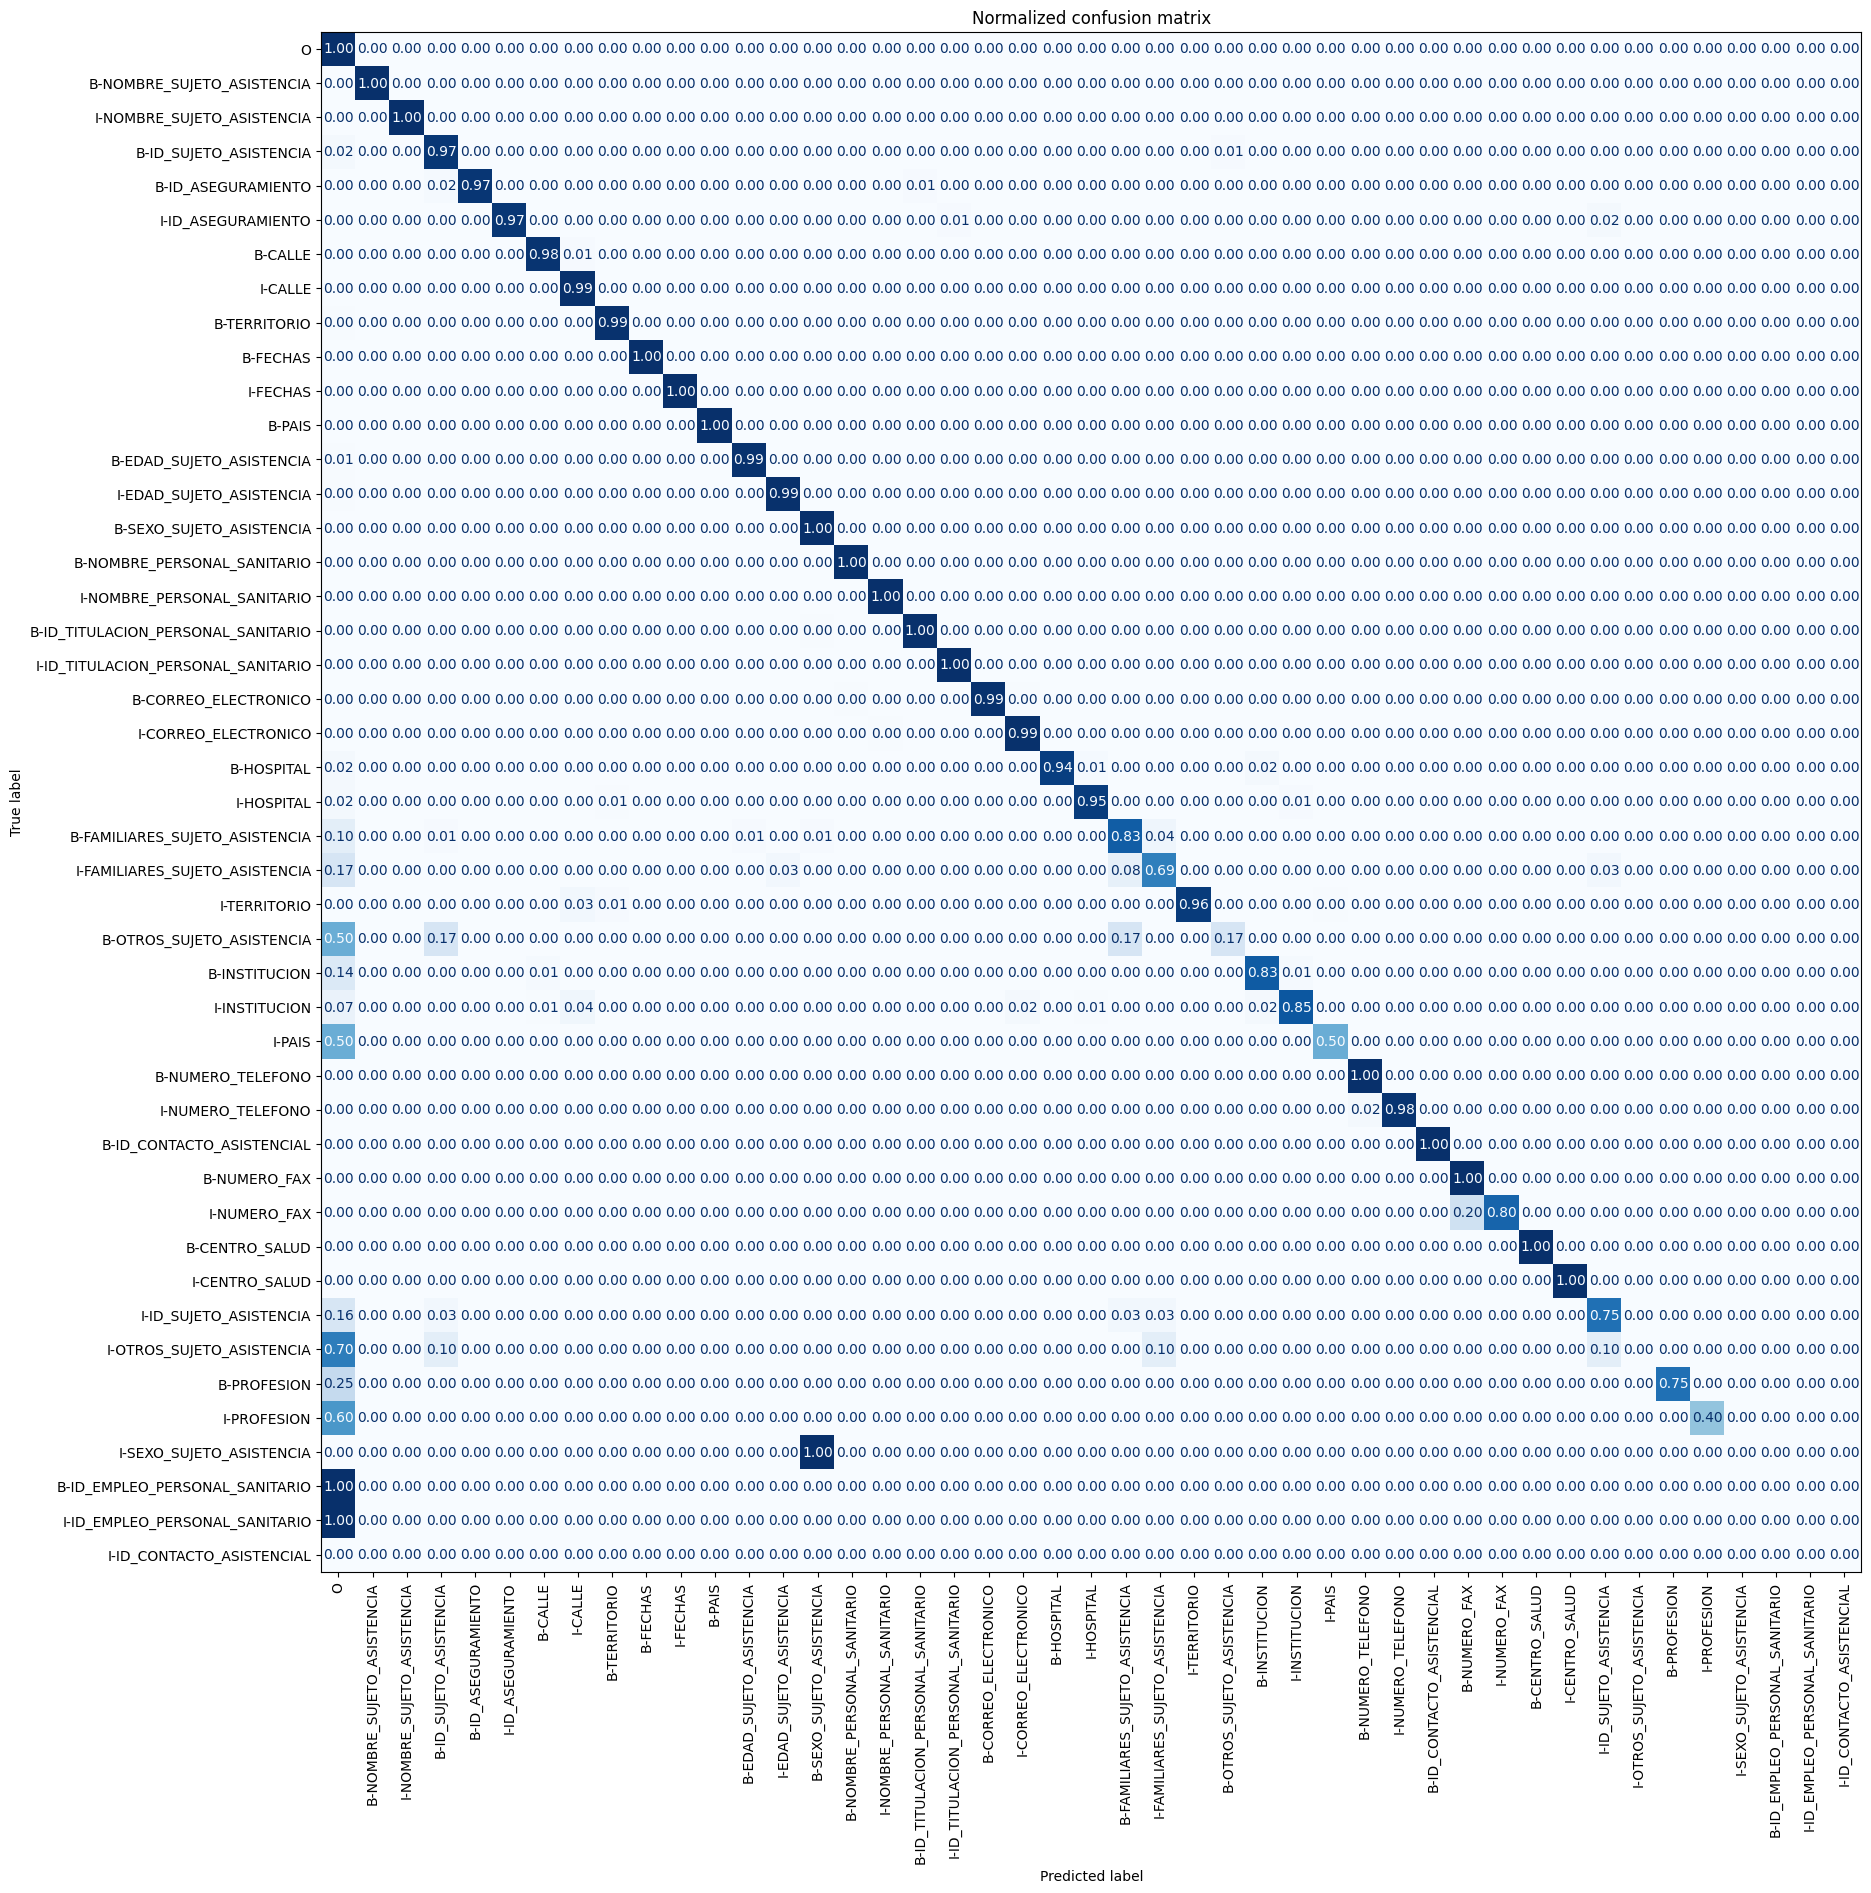

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import string

cm = confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], normalize="true", labels=tags.names)
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags.names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation="vertical")
plt.title("Normalized confusion matrix")
plt.show()

A partir del gráfico, podemos ver que nuestro modelo tiende a confundir tambien las entidades ``B-FAMILIARES_SUJETO_ASISTENCIA`` y ``I-FAMILIARES_SUJETO_ASISTENCIA`` entre ellas y con ``O``. Por lo demás, es bastante bueno en la clasificación de las entidades restantes, lo que queda claro por la naturaleza casi diagonal de la matriz de confusión.

Ahora que hemos examinado los errores a nivel de token, pasemos a ver las secuencias con grandes pérdidas. Para este cálculo, volveremos a visitar nuestro DataFrame "no explotado" y calcularemos la pérdida total sumando la pérdida por token. Para ello, escribamos primero una función que nos ayude a mostrar las secuencias de tokens con las etiquetas y las pérdidas:

In [52]:
pd.set_option('display.max_rows', None)

def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample.T)

,tokens,labels,preds,losses
0,▁,O,O,0.00
1,Respons,IGN,O,0.00
2,able,IGN,O,0.00
3,▁clínico,O,O,0.00
4,▁:,O,O,0.00
5,▁Dr,O,O,0.00
6,▁,O,O,0.00
7,.,IGN,O,0.00
8,▁Lluís,B-NOMBRE_PERSONAL_SANITARIO,B-NOMBRE_PERSONAL_SANITARIO,0.00
9,▁Valeri,I-NOMBRE_PERSONAL_SANITARIO,I-NOMBRE_PERSONAL_SANITARIO,0.00


,tokens,labels,preds,losses
0,▁Se,O,O,0.00
1,▁trata,O,O,0.00
2,▁de,O,O,0.00
3,▁una,O,O,0.00
4,▁familia,B-FAMILIARES_SUJETO_ASISTENCIA,O,5.40
5,▁de,I-FAMILIARES_SUJETO_ASISTENCIA,O,17.31
6,▁nu,I-FAMILIARES_SUJETO_ASISTENCIA,B-FAMILIARES_SUJETO_ASISTENCIA,7.51
7,eve,IGN,B-FAMILIARES_SUJETO_ASISTENCIA,0.00
8,▁miembros,I-FAMILIARES_SUJETO_ASISTENCIA,O,7.80
9,▁,O,O,0.00


,tokens,labels,preds,losses
0,▁La,O,O,-0.00
1,▁explora,O,O,-0.00
2,ción,IGN,O,0.00
3,▁exhaust,O,O,-0.00
4,iva,IGN,O,0.00
5,▁de,O,O,-0.00
6,▁la,O,O,-0.00
7,▁paciente,O,O,0.00
8,▁durante,O,O,-0.00
9,▁el,O,O,-0.00


Otra cosa que hemos observado antes es que los tokens "pareja", "Merc" o "matern" tienen una pérdida relativamente alta. Veamos algunos ejemplos de secuencias con un paréntesis de apertura:

In [53]:
pd.set_option('display.max_rows', None)
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581pareja" in x)].head(3)
for i, sample in enumerate(get_samples(df_tmp)):
    if i == 0:
        display(sample.T.iloc[151:165].T)
    else:
        display(sample.T.iloc[40:50].T)

,151,152,153,154,155,156,157,158,159,160,161,162,163,164
tokens,▁de,▁de,terior,o,▁de,▁la,▁relación,▁de,▁pareja,▁que,▁manten,ía,▁,","
labels,O,O,IGN,IGN,O,O,O,O,B-FAMILIARES_SUJETO_ASISTENCIA,O,O,IGN,O,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.30,0.00,0.00,0.00,0.00,0.00


,40,41,42,43,44,45,46,47,48,49
tokens,.,▁Rela,ción,▁de,▁pareja,▁estable,▁desde,▁hacía,▁varios,▁años
labels,IGN,O,IGN,O,B-FAMILIARES_SUJETO_ASISTENCIA,O,O,O,O,O
preds,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,16.20,0.00,0.00,0.00,0.00,0.00


,40,41,42,43,44,45,46,47,48,49
tokens,o,▁por,▁parte,▁de,▁su,▁pareja,▁,",",▁hab,iendo
labels,IGN,O,O,O,O,B-FAMILIARES_SUJETO_ASISTENCIA,O,IGN,O,IGN
preds,O,O,O,O,O,B-FAMILIARES_SUJETO_ASISTENCIA,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


En la primera y segunda frase vemos claramente que el token " pareja" no se detecta correctamente como ``ID-OTRO_SUJETO_ASISTENCIA``. 

En nuestro caso, el conjunto de datos ha sido etiquetado por expertos y verificado varias veces, lo que nos permite evitar en lo posible los errores de etiquetado que no somos capaces de detectar ahora.

Con un análisis relativamente sencillo, hemos identificado algunos puntos débiles en nuestro modelo, pero no tanto en el conjunto de datos que parece estar correctamente etiquetado. En un caso de uso real, repetiríamos este paso, limpiando el conjunto de datos, volviendo a entrenar el modelo y analizando los nuevos errores hasta que estuviéramos satisfechos con el rendimiento.

### SubTrack1

Hasta ahora nos hemos centrado a las métricas obtenidas a partir de los subtoken en el conjunto de datos de validación. Para obtener la métrica correspondiente a la **SubTrack1** debemos asociar una etiqueta a cada token.

Cogemos un ejemplo extraído del conjunto de datos de test que tiene entidades a detectar.

In [32]:
example = ds["test"][0]

tokens = example["tokens"]
ner_tags = example["ner_tags"]
labels = [tags.int2str(idx) for idx in ner_tags]
pd.DataFrame([tokens, labels], index=["tokens", "labels"])

,0,1,2,3,4,5
tokens,NASS,:,75,46815490,26,.
labels,O,O,B-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,O


Vamos a crear los subtokens correspondientes utilizando nuestro tokenizador ``xlmr_tokenizer``.

In [33]:
tokenized_inputs = xlmr_tokenizer(tokens, truncation=True, is_split_into_words=True)
input_ids = tokenized_inputs["input_ids"]
input_tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"])
pd.DataFrame([input_ids, input_tokens], index=["IDs", "Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
IDs,0,79518,294,152,4948,6,157041,1837,88925,1381,6,5,2
Tokens,<s>,▁NAS,S,▁:,▁75,▁,468,15,490,▁26,▁,.,</s>


Ahora calculamos las predicciones hechas por el modelo como lo hemos hecho en la function ``tag_text()``. Para empezar calculamos las predicciones por cada subtokens.

In [34]:
# Encode the sequence into IDs as tensor
input_ids = xlmr_tokenizer(
    tokens, return_tensors="pt", truncation=True, is_split_into_words=True,
    padding=True).input_ids.to(device)
    
# Get predictions as distribution over 13 possible classes
outputs = model(input_ids)[0]

# Take argmax to get most likely class per token
predictions = torch.argmax(outputs, dim=2)

# Visualize the predictions
pd.DataFrame(
    [
        input_tokens,
        [tags.int2str(pred) for pred in predictions.cpu().numpy()][0]
    ],
    index=["Tokens", "Predictions"]
).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,<s>,▁NAS,S,▁:,▁75,▁,468,15,490,▁26,▁,.,</s>
Predictions,O,O,O,O,B-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,O,O,I-ID_ASEGURAMIENTO


Emparejáramos los tokens con las etiquetas correspondientes utilizando el método ``words_ids``. Así pasaremos de 22 sub-tokens etiquetados a 15 tokens etiquetados.

In [35]:
# Store predicted IDs into a list
predicted_ids = []

for idx, (label, prediction) in enumerate(zip([ner_tags], predictions.cpu().numpy())):

    # Get words IDs in order to associate each token to it's corresponding words
    word_ids = tokenized_inputs.word_ids(batch_index=idx)

    previous_word_idx = None

    # initialize the predictions
    label_num = len(label)
    prediction_ids = [tags.str2int("O")]*label_num

    for subtoken_idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            pass
        else:
            prediction_ids[word_idx] = prediction[subtoken_idx]
        previous_word_idx = word_idx
    predicted_ids.append(prediction_ids)

    # Decode label id to label names
    y_pred = list(map(tags.int2str, predicted_ids))

# Visualize the predictions
pd.DataFrame([tokens, labels, y_pred[0]], index=["Tokens", "Gold", "Predicción"])

,0,1,2,3,4,5
Tokens,NASS,:,75,46815490,26,.
Gold,O,O,B-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,O
Predicción,O,O,B-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,I-ID_ASEGURAMIENTO,O


Para hacer la prediction sobre todo nuestros datos de test vamos a envolver los pasos anteriores en una función de ayuda.

In [36]:
def predict(batch, model, tokenizer):

    # Store tokenize inputs
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)

    # Store predicted IDs into a list
    predicted_ids = []

    # Encode the sequence into IDs as tensor
    input_ids = tokenizer(batch["tokens"], return_tensors="pt", truncation=True,
        is_split_into_words=True, padding=True).input_ids.to(device)

    # Get predictions as distribution over 13 possible classes
    outputs = model(input_ids)[0]

    # Take argmax to get most likely class per token
    subtoken_predictions = torch.argmax(outputs, dim=2).cpu().numpy()

    for idx, (label, prediction) in enumerate(zip(batch["ner_tags"], subtoken_predictions)):

        # Get words IDs in order to associate each token to it's corresponding words
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        # words = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][idx])

        previous_word_idx = None

        # initialize the predictions
        label_num = len(label)
        token_prediction_ids = [tags.str2int("O")]*label_num

        for subtoken_idx, word_idx in enumerate(word_ids):
            if word_idx is None or word_idx == previous_word_idx:
                pass
            else:
                token_prediction_ids[word_idx] = prediction[subtoken_idx]
            previous_word_idx = word_idx
        predicted_ids.append(token_prediction_ids)

    # Decode label id to label names
    y_pred = list(map(tags.int2str, predicted_ids))

    batch["predicted_label"] = y_pred
    return batch

Ahora podemos aplicar esta función a todo nuestro dataset utilizando ``map()`` y calcular el escore $F_{1}$ micro sobre cada conjunto de datos:

In [39]:
ds = ds.map(lambda batch: predict(batch, model, xlmr_tokenizer), batched=True, batch_size=1)

  0%|          | 0/10312 [00:00<?, ?ba/s]

  0%|          | 0/5268 [00:00<?, ?ba/s]

  0%|          | 0/5155 [00:00<?, ?ba/s]

Obtenemos las etiquetas reales en la variable ``y_true`` y las predichas por nuestro modelo en la variable ``y_pred``. Por último, utilizamos la función ``f1_score()`` para calcular la puntuación $F_{1}$ de cada conjunto de datos.

In [55]:
from seqeval.metrics import f1_score

f1_dict = {split: f1_score(ds[split]["ner_tags_str"], ds[split]["predicted_label"]) for split in ds}
f1 = pd.DataFrame.from_dict(f1_dict, orient="index", columns=["f1 micro"]).T
f1

,train,dev,test
f1 micro,0.997707,0.972606,0.97389


El score $F_{1}$ micro sobre el conjunto de desarrollo tiene un valor de 97.26 . Podemos ver que el escore a nivel de subtokens es ligeramente superior. En cuando al $F_{1}$ micro del conjunto de test, supera ligeramente, con un valor de 97.39 el escore sobre le conjunto de desarrollo. Nuestro modelo generaliza correctamente a datos nuevos!

Si queremos tener una visión mas amplia de los resultados sobre el conjunto de test podemos de nuevo utilizar la función ``classification_report()``.

In [31]:
y_true = ds["test"]["ner_tags_str"]
y_pred =  ds["test"]["predicted_label"]

print(classification_report(y_true, y_pred, digits=4))

                                  precision    recall  f1-score   support

                           CALLE     0.9524    0.9685    0.9604       413
                    CENTRO_SALUD     1.0000    0.8333    0.9091         6
              CORREO_ELECTRONICO     0.9880    0.9920    0.9900       249
          EDAD_SUJETO_ASISTENCIA     0.9791    0.9942    0.9866       518
    FAMILIARES_SUJETO_ASISTENCIA     0.7033    0.7901    0.7442        81
                          FECHAS     0.9902    0.9951    0.9927       611
                        HOSPITAL     0.9219    0.9077    0.9147       130
                ID_ASEGURAMIENTO     1.0000    0.9949    0.9975       198
         ID_CONTACTO_ASISTENCIAL     0.8837    0.9744    0.9268        39
            ID_SUJETO_ASISTENCIA     0.9724    0.9965    0.9843       283
ID_TITULACION_PERSONAL_SANITARIO     0.9957    1.0000    0.9979       234
                     INSTITUCION     0.5833    0.6269    0.6043        67
       NOMBRE_PERSONAL_SANITARIO     